In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
from joblib import dump
from IPython.display import IFrame
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
# import dask.dataframe as dd


In [26]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [27]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_test_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_test_train_lag{ndays}_pre_processing.csv', index_col=None)
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))

In [28]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1622156, 102) (1622156, 1) (1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


### Analyze the regression relation

#### Use OLS regression

In [29]:
def analyze_OLS(x,y):
    x = sm.add_constant(x)  
    model = sm.OLS(y, x,hasconst=True)
    results = model.fit()
    summary = results.summary()
    # print(summary)
    return summary
print(analyze_OLS(X,y))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 1.208e+05
Date:                Sat, 06 Jul 2024   Prob (F-statistic):               0.00
Time:                        08:29:03   Log-Likelihood:            -5.9014e+05
No. Observations:             1622156   AIC:                         1.180e+06
Df Residuals:                 1622056   BIC:                         1.182e+06
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

#### Use Linear machine learning model

In [30]:
def print_sorted_coefficients(model, model_name, feature_names):
    coef = model.coef_
    if len(coef.shape) > 1:
        coef = coef[0]
    sorted_indices = np.argsort(-np.abs(coef))  
    sorted_coef = coef[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    for i, (name, value) in enumerate(zip(sorted_feature_names, sorted_coef)):
        print(f"{model_name} Coefficient {i + 1}: {name}, Coefficient: {value}")

In [31]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_valid)

print_sorted_coefficients(linear_model, "Linear Regression", X_train.columns)
print("Linear Regression intercept:", linear_model.intercept_)





Linear Regression Coefficient 1: shortwave_radiation, Coefficient: -18202.954718509456
Linear Regression Coefficient 2: direct_solar_radiation_hd_7d, Coefficient: 13159.632954971958
Linear Regression Coefficient 3: diffuse_radiation, Coefficient: 6053.4897630092955
Linear Regression Coefficient 4: shortwave_radiation_hl_7d, Coefficient: -5204.992230207955
Linear Regression Coefficient 5: direct_solar_radiation_hl_7d, Coefficient: 3830.6608694607417
Linear Regression Coefficient 6: diffuse_radiation_hl_7d, Coefficient: 1814.927058536048
Linear Regression Coefficient 7: installed_capacity, Coefficient: 0.12340799196307004
Linear Regression Coefficient 8: eic_count, Coefficient: -0.057915268793770194
Linear Regression Coefficient 9: is_consumption, Coefficient: 0.04674447246971464
Linear Regression Coefficient 10: temperature_hd_7d, Coefficient: -0.031122266158620328
Linear Regression Coefficient 11: dewpoint_hd_7d, Coefficient: 0.03082564402964176
Linear Regression Coefficient 12: surfac

In [32]:
print("Linear Regression R²:", r2_score(y_valid, y_pred_linear))
print("Linear Regression MAE:", mean_absolute_error(y_valid, y_pred_linear))

Linear Regression R²: 0.8684102284978384
Linear Regression MAE: 0.21321252683929973


In [33]:
Lasso_model = Lasso(alpha=1.0)
Lasso_model.fit(X_train, y_train)
y_pred_Lasso = Lasso_model.predict(X_valid)



print_sorted_coefficients(Lasso_model, "Laso Regression", X_train.columns)
print("Lasso Regression intercept:", Lasso_model.intercept_)







Laso Regression Coefficient 1: target_1, Coefficient: 0.0010063120944599367
Laso Regression Coefficient 2: county, Coefficient: -0.0
Laso Regression Coefficient 3: windspeed_10m, Coefficient: -0.0
Laso Regression Coefficient 4: cloudcover_high_hd_7d, Coefficient: -0.0
Laso Regression Coefficient 5: cloudcover_mid_hd_7d, Coefficient: 0.0
Laso Regression Coefficient 6: cloudcover_low_hd_7d, Coefficient: 0.0
Laso Regression Coefficient 7: cloudcover_total_hd_7d, Coefficient: 0.0
Laso Regression Coefficient 8: surface_pressure, Coefficient: 0.0
Laso Regression Coefficient 9: snowfall_hd_7d, Coefficient: 0.0
Laso Regression Coefficient 10: rain, Coefficient: -0.0
Laso Regression Coefficient 11: dewpoint_hd_7d, Coefficient: -0.0
Laso Regression Coefficient 12: temperature_hd_7d, Coefficient: -0.0
Laso Regression Coefficient 13: total_precipitation_fl_7d, Coefficient: 0.0
Laso Regression Coefficient 14: snowfall_fl_7d, Coefficient: 0.0
Laso Regression Coefficient 15: surface_solar_radiation_d

In [34]:
print("Lasso Regression R²:", r2_score(y_valid, y_pred_Lasso))
print("Lasso Regression MAE:", mean_absolute_error(y_valid, y_pred_Lasso))

Lasso Regression R²: 0.880248561211806
Lasso Regression MAE: 0.10874420875466223


### Build Decision Tree and Improve in valid set

In [5]:
dt_model = DecisionTreeRegressor(random_state=42, **best_params['dt_grid_search'].item())
dt_model.fit(X_train, y_train)
dump(dt_model, f'{save_dir}/dt_model_tuning.joblib')



['../../exps/exp/dt_model_tuning.joblib']

In [6]:
dt_valid_predictions = dt_model.predict(X_valid)
dt_valid_mae = mean_absolute_error(y_valid, dt_valid_predictions)
dt_valid_r2 = r2_score(y_valid, dt_valid_predictions)
print(f"Decision Tree - Validation MAE: {dt_valid_mae:.3f}, Validation R2: {dt_valid_r2:.3f}")


Decision Tree - Validation MAE: 0.096, Validation R2: 0.902


In [7]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [8]:
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature {X.columns[index]} ({importances[index]})")

Feature ranking:
1. feature target_1 (0.8832504665028397)
2. feature weekday (0.0255004490735803)
3. feature installed_capacity (0.01920882834162093)
4. feature segment (0.0179260018597309)
5. feature surface_solar_radiation_downwards_fl (0.010985337829746734)
6. feature cos(hour) (0.00866014409154498)
7. feature cos(dayofyear) (0.005660475895634168)
8. feature prediction_unit_id (0.005374861550821603)
9. feature surface_solar_radiation_downwards (0.0034681201403296185)
10. feature is_consumption (0.0026794584537571226)
11. feature eic_count (0.0024373929478614664)
12. feature direct_solar_radiation_fl (0.0018054459985208803)
13. feature sin(hour) (0.0015156543256500475)
14. feature data_block_id (0.0013841714697937738)
15. feature cloudcover_low_fl (0.0012567693869992994)
16. feature county (0.00125137141418481)
17. feature data_block_id_right (0.000977567171512446)
18. feature direct_solar_radiation (0.0005367345044879626)
19. feature diffuse_radiation (0.0005019277445264509)
20. fea

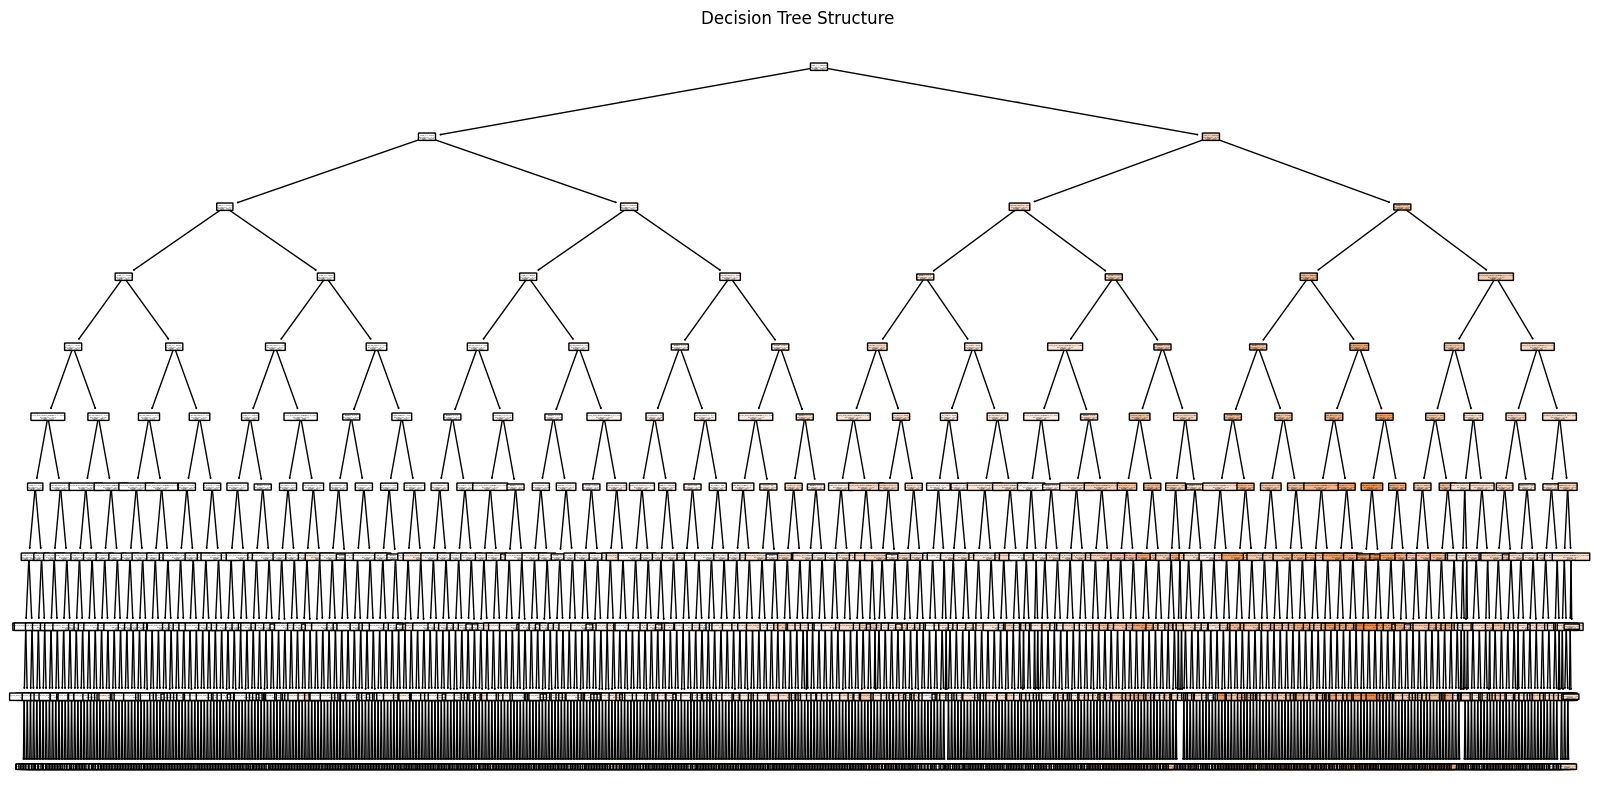

In [9]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

### Use LIME, SHAP to explained

100%|===================| 533376/535312 [00:31<00:00]        

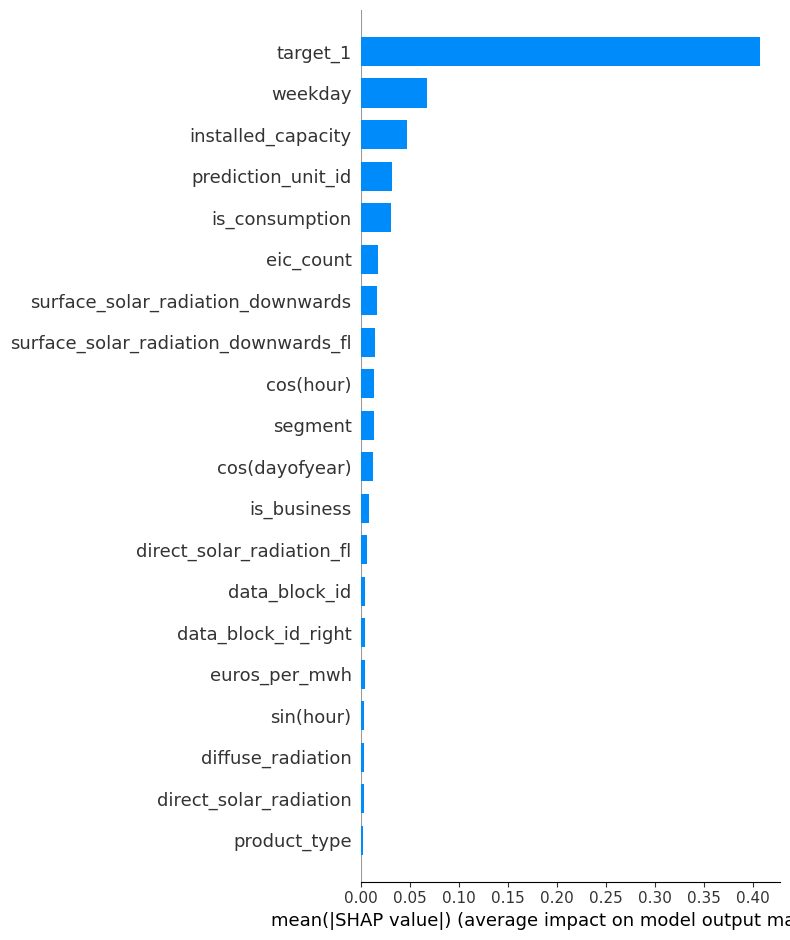

In [10]:
explainer_dt = shap.Explainer(dt_model, X_train)
shap_values_dt = explainer_dt(X_valid, check_additivity=False)


shap.summary_plot(shap_values_dt, X_valid, plot_type="bar", title="SHAP Decision Tree Feature Importance")


In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_dt = explainer.explain_instance(X_valid.iloc[0].values, dt_model.predict)
file_name = f"{save_dir}/lime_explanation_dt.html"

lime_exp_dt.save_to_file(file_name)
lime_exp_dt.show_in_notebook()


### Build LGBM and Improve in valid set

In [12]:
# Train LightGBM model
lgbm_model = lgb.LGBMRegressor(objective='regression',**best_params['lgb_grid_search'].item())
lgbm_model.fit(X_train, y_train)
dump(lgbm_model, f'{save_dir}/lgbm_model_tuning.joblib')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21971
[LightGBM] [Info] Number of data points in the train set: 1086844, number of used features: 101
[LightGBM] [Info] Start training from score -0.024564


['../../exps/exp/lgbm_model_tuning.joblib']

In [13]:
lgbm_model_predictions = lgbm_model.predict(X_valid)
lgbm_model_mae = mean_absolute_error(y_valid, lgbm_model_predictions)
lgbm_model_r2 = r2_score(y_valid, lgbm_model_predictions)
print(f"LGBM model - Validation MAE: {lgbm_model_mae:.3f}, Validation R2: {lgbm_model_r2:.3f}")

LGBM model - Validation MAE: 0.076, Validation R2: 0.949


### Use LIME, SHAP to explained

100%|===================| 534999/535312 [19:29<00:00]        

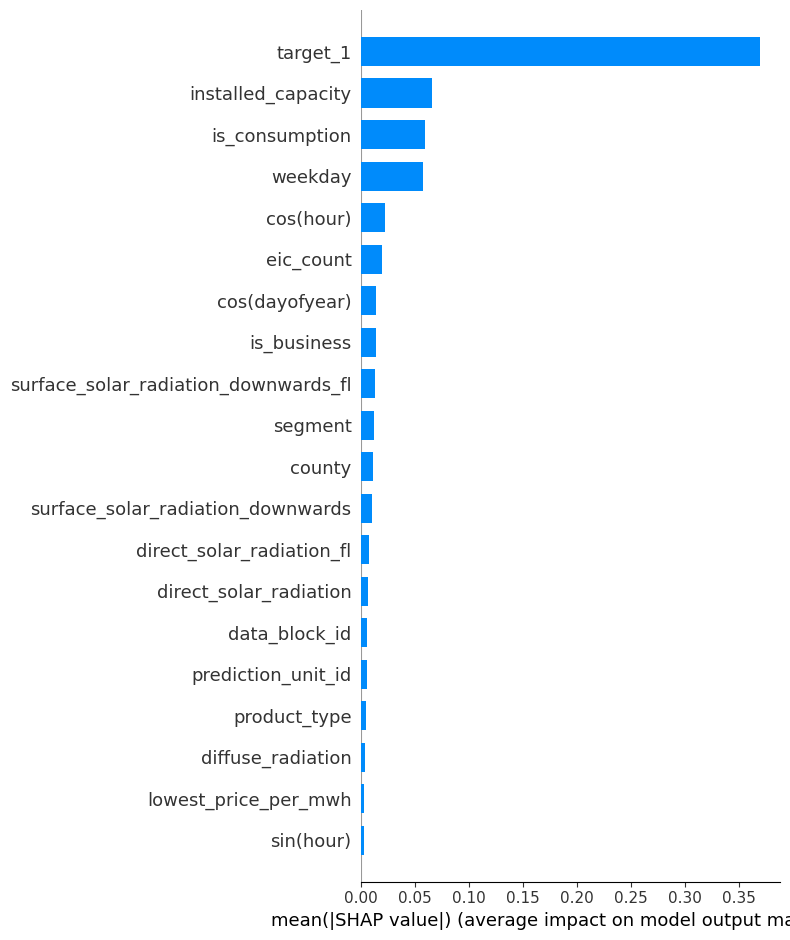

In [14]:
explainer_lgbm = shap.Explainer(lgbm_model, X_train)
shap_values_lgbm = explainer_lgbm(X_valid, check_additivity=False)


shap.summary_plot(shap_values_lgbm, X_valid, plot_type="bar", title="SHAP LGBM Feature Importance")



In [15]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_lgbm = explainer.explain_instance(X_valid.iloc[0].values, lgbm_model.predict)
file_name = f"{save_dir}/lime_explanation_lgbm.html"

lime_exp_lgbm.save_to_file(file_name)
lime_exp_lgbm.show_in_notebook()
